In [1]:

import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
from collections import defaultdict
import random

/home/moonlab/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:


class Action(Enum):
    """Defines possible actions for each agent"""
    UP = (-1, 0)
    DOWN = (1, 0)
    LEFT = (0, -1)
    RIGHT = (0, 1)
    STAY = (0, 0)

In [3]:


class GridWorld:
    def __init__(self, size=10, random_start=False):
        """
        Initialize the grid world environment
        Args:
            size (int): Size of the square grid (default: 10x10)
            random_start (bool): Whether to randomize agent starting positions
        """
        self.size = size
        self.grid = np.zeros((size, size))  # Empty grid

        # Obstacles
        self.obstacles = [
            (0, 4), (1, 4), (2, 4), (2, 5),
            (4, 0), (4, 1), (4, 2), (5, 2),
            (4, 7), (4, 8), (4, 9), (5, 7),
            (7, 4), (7, 5), (8, 5), (9, 5)
        ]
        for obs in self.obstacles:
            self.grid[obs] = 1

        # Agent goals and initial positions
        self.agents = {
            0: (None, (5, 8)),
            1: (None, (5, 1)),
            2: (None, (1, 5)),
            3: (None, (8, 4))
        }
        self.random_start = random_start
        self.reset_agents()

    def reset_agents(self):
        """Reset agent positions, randomize if enabled"""
        for agent_id in self.agents:
            goal = self.agents[agent_id][1]
            while True:
                start = (
                    random.randint(0, self.size - 1),
                    random.randint(0, self.size - 1)
                ) if self.random_start else (
                    (1, 1), (8, 8), (8, 1), (1, 8))[agent_id]

                if start not in self.obstacles and start != goal:
                    self.agents[agent_id] = (start, goal)
                    break

        self.current_positions = {
            agent_id: start for agent_id, (start, _) in self.agents.items()
        }

    def get_valid_actions(self, agent_id):
        """Get valid actions for a specific agent"""
        current_pos = self.current_positions[agent_id]
        valid_actions = []
        for action in Action:
            new_pos = (
                current_pos[0] + action.value[0],
                current_pos[1] + action.value[1]
            )
            if self.is_valid_position(new_pos, agent_id):
                valid_actions.append(action)
        return valid_actions

    def is_valid_position(self, position, agent_id):
        """Check if a position is valid for an agent to move to"""
        x, y = position
        if not (0 <= x < self.size and 0 <= y < self.size):
            return False
        if position in self.obstacles:
            return False
        if position in self.current_positions.values() and self.current_positions[agent_id] != position:
            return False
        return True

    def visualize(self):
        """Visualize the current grid"""
        plt.figure(figsize=(8, 8))
        plt.grid(True)
        for obs in self.obstacles:
            plt.fill([obs[1], obs[1] + 1, obs[1] + 1, obs[1]],
                     [obs[0], obs[0], obs[0] + 1, obs[0] + 1],
                     color='gray')
        colors = ['green', 'yellow', 'lightblue', 'purple']
        for agent_id, ((start_x, start_y), (goal_x, goal_y)) in self.agents.items():
            current_x, current_y = self.current_positions[agent_id]
            plt.fill([current_y, current_y + 1, current_y + 1, current_y],
                     [current_x, current_x, current_x + 1, current_x + 1],
                     color=colors[agent_id], alpha=0.5)
            plt.plot(goal_y + 0.5, goal_x + 0.5, '+', color=colors[agent_id],
                     markersize=15, markeredgewidth=2)
        plt.xlim(0, self.size)
        plt.ylim(self.size, 0)
        plt.xticks(range(self.size))
        plt.yticks(range(self.size))
        plt.show()

    def move_agent(self, agent_id, action):
        """Move the specified agent according to the action."""
        current_pos = self.current_positions[agent_id]
        new_pos = (
            current_pos[0] + action.value[0],
            current_pos[1] + action.value[1]
        )

        # Only move if the new position is valid
        if self.is_valid_position(new_pos, agent_id):
            self.current_positions[agent_id] = new_pos

In [4]:




class MAPF:
    def __init__(self, env, learning_rate=0.3, discount_factor=0.999, epsilon=1.0, epsilon_min=0.1, decay_rate=0.01):
        self.env = env
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon  # Initial epsilon for exploration
        self.epsilon_min = epsilon_min  # Minimum epsilon value
        self.decay_rate = decay_rate  # Epsilon decay rate
        self.q_tables = {
            agent_id: defaultdict(lambda: {action: 0.0 for action in Action})
            for agent_id in env.agents}

    def decay_epsilon(self):
        """Decay epsilon after each episode."""
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.decay_rate))


    def get_state_key(self):
        return tuple(sorted(self.env.current_positions.items()))

    def choose_action(self, agent_id):
        state = self.get_state_key()
        if random.random() < self.epsilon:
            return random.choice(self.env.get_valid_actions(agent_id))
        q_values = self.q_tables[agent_id][state]
        return max(q_values, key=q_values.get)

    def update_q_table(self, agent_id, state, action, reward, next_state):
        q_values = self.q_tables[agent_id]
        max_future_q = max(q_values[next_state].values(), default=0)
        current_q = q_values[state][action]
        q_values[state][action] = current_q + self.lr * (reward + self.gamma * max_future_q - current_q)

    def train_episode(self, max_steps=700):
        self.env.reset_agents()
        total_steps = 0
        for step in range(max_steps):
            if all(pos == goal for agent_id, (_, goal) in self.env.agents.items()
                   for pos in [self.env.current_positions[agent_id]]):
                break
            state = self.get_state_key()
            for agent_id in self.env.agents:
                action = self.choose_action(agent_id)
                old_pos = self.env.current_positions[agent_id]
                self.env.move_agent(agent_id, action)
                new_pos = self.env.current_positions[agent_id]
                reward = 100 if new_pos == self.env.agents[agent_id][1] else -1
                next_state = self.get_state_key()
                self.update_q_table(agent_id, state, action, reward, next_state)
            total_steps += 1
        return total_steps
    
    def train(self, episodes=1000, window_size=1000):
        """Train the agents and plot the moving average of steps per episode."""
        episode_steps = []  # To store steps for each episode

        for episode in range(episodes):
            steps = self.train_episode()  # Run one training episode
            episode_steps.append(steps)  # Track the number of steps
            self.decay_epsilon()

            # Print progress every 1000 episodes
            if (episode + 1) % 1000 == 0:
                print(f"Episode {episode + 1}, Steps: {steps}")

        # Compute the moving average
        moving_avg = np.convolve(episode_steps, np.ones(window_size) / window_size, mode='valid')

        # Plot the training progress
        plt.figure(figsize=(10, 6))
        plt.plot(range(window_size, episodes + 1), moving_avg, label=f'Moving Average (Window: {window_size})', color='blue')
        plt.xlabel('Episode')
        plt.ylabel('Steps')
        plt.title('Training Progress: Moving Average of Steps per Episode')
        plt.legend()
        plt.grid()
        plt.show()


    def test(self, max_steps=100):
        
        """Test the agents using the learned policy."""
        self.env.reset_agents()  # Reset agents to initial positions
        total_steps = 0
        print("Testing the trained model...\nInitial environment:")
        self.env.visualize()

        for step in range(max_steps):
            if all(
                pos == goal
                for agent_id, (_, goal) in self.env.agents.items()
                for pos in [self.env.current_positions[agent_id]]
            ):
                print(f"All agents reached their goals in {step} steps!")
                break

            state = self.get_state_key()
            for agent_id in self.env.agents:
                action = max(self.q_tables[agent_id][state], key=self.q_tables[agent_id][state].get)
                self.env.move_agent(agent_id, action)

            total_steps += 1
            if step % 5 == 0:  # Visualize every 5 steps
                print(f"Step {step + 1}:")
                self.env.visualize()

        if total_steps == max_steps:
            print("Maximum steps reached before all agents could reach their goals.")


Episode 1000, Steps: 700
Episode 2000, Steps: 700
Episode 3000, Steps: 700
Episode 4000, Steps: 700
Episode 5000, Steps: 700
Episode 6000, Steps: 700
Episode 7000, Steps: 700
Episode 8000, Steps: 700
Episode 9000, Steps: 700
Episode 10000, Steps: 700
Episode 11000, Steps: 700
Episode 12000, Steps: 700
Episode 13000, Steps: 510
Episode 14000, Steps: 588
Episode 15000, Steps: 700
Episode 16000, Steps: 700
Episode 17000, Steps: 659
Episode 18000, Steps: 700
Episode 19000, Steps: 514
Episode 20000, Steps: 700
Episode 21000, Steps: 700
Episode 22000, Steps: 700
Episode 23000, Steps: 700
Episode 24000, Steps: 700
Episode 25000, Steps: 700
Episode 26000, Steps: 520
Episode 27000, Steps: 700
Episode 28000, Steps: 700
Episode 29000, Steps: 691
Episode 30000, Steps: 700
Episode 31000, Steps: 700
Episode 32000, Steps: 639
Episode 33000, Steps: 700
Episode 34000, Steps: 481
Episode 35000, Steps: 700
Episode 36000, Steps: 388
Episode 37000, Steps: 700
Episode 38000, Steps: 700
Episode 39000, Steps:

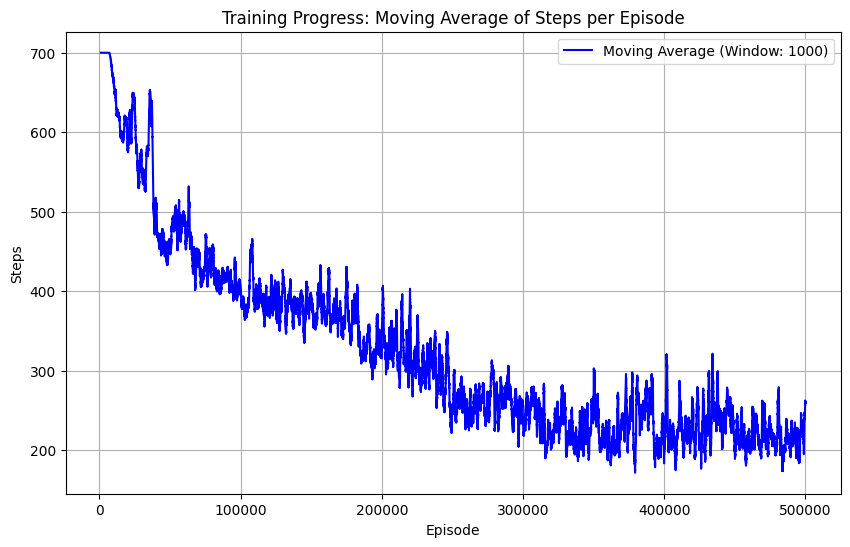

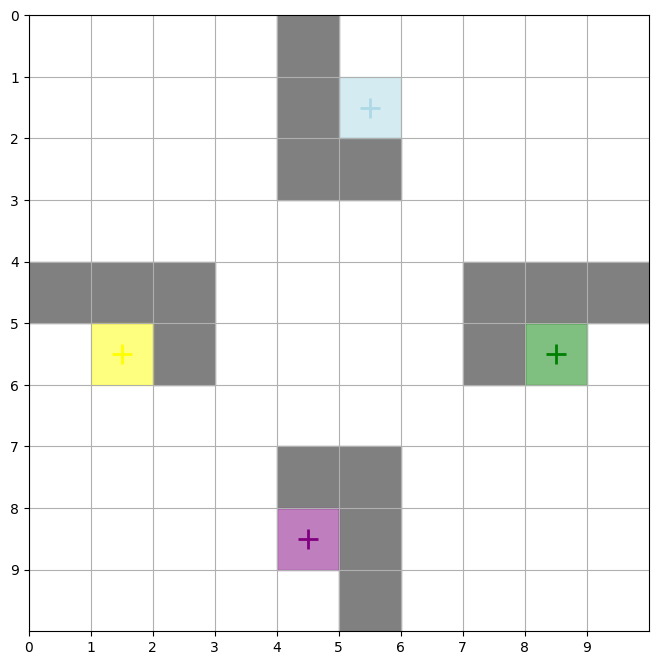

In [5]:

env = GridWorld()
mapf = MAPF(env)
mapf.train(episodes=500000)  # Specify the number of episodes
env.visualize()  # Visualize the final state of the environment


Testing the trained model...
Initial environment:


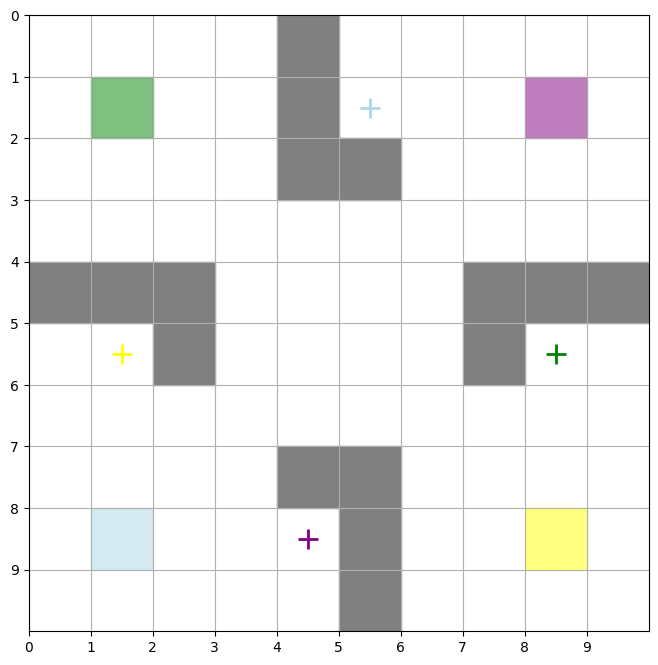

Step 1:


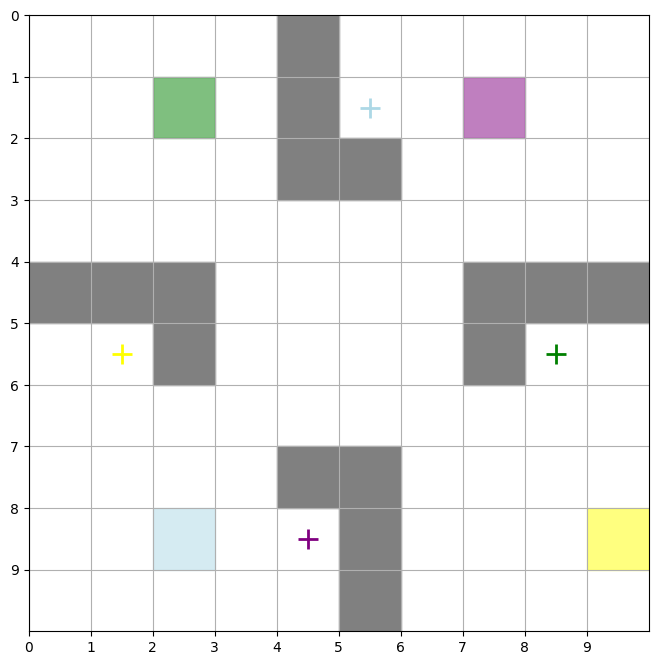

Step 6:


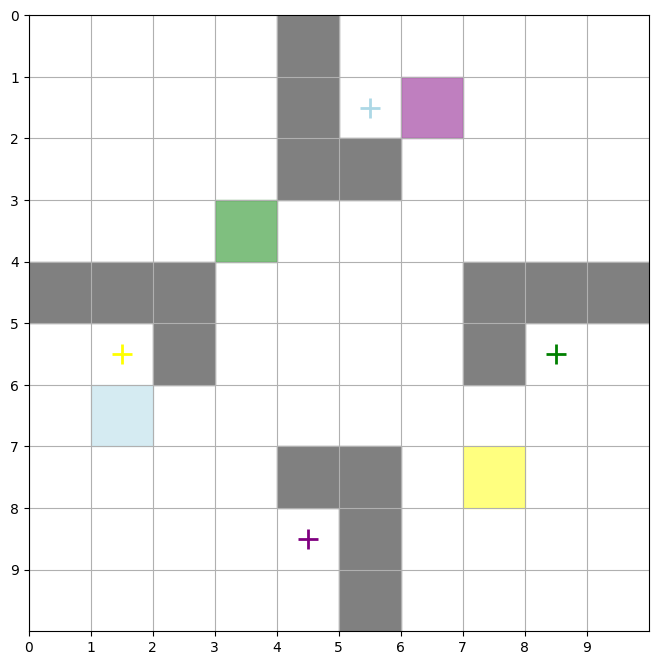

Step 11:


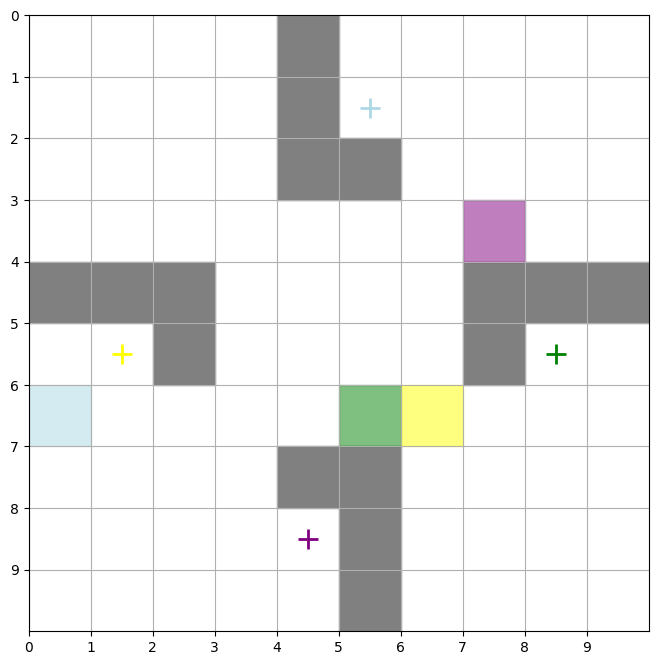

Step 16:


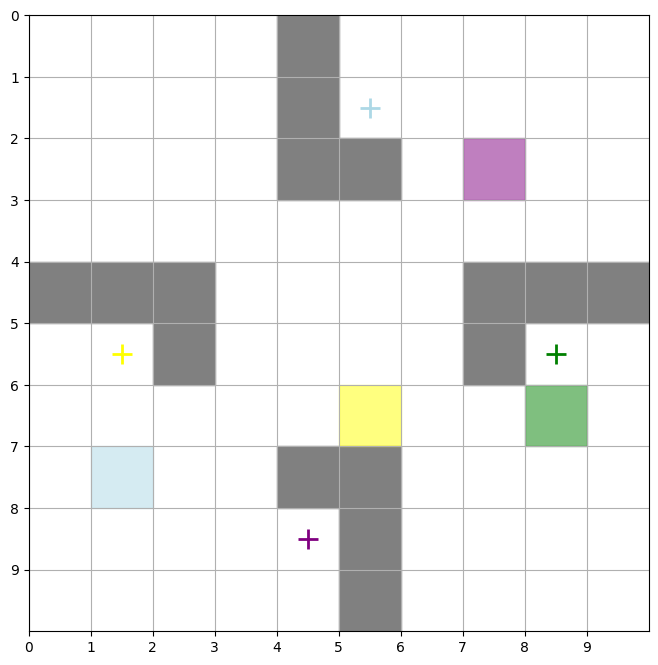

Step 21:


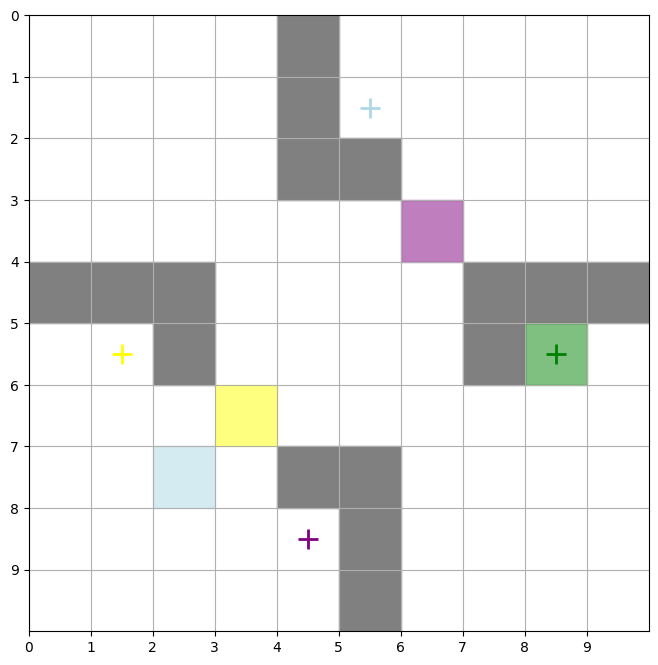

Step 26:


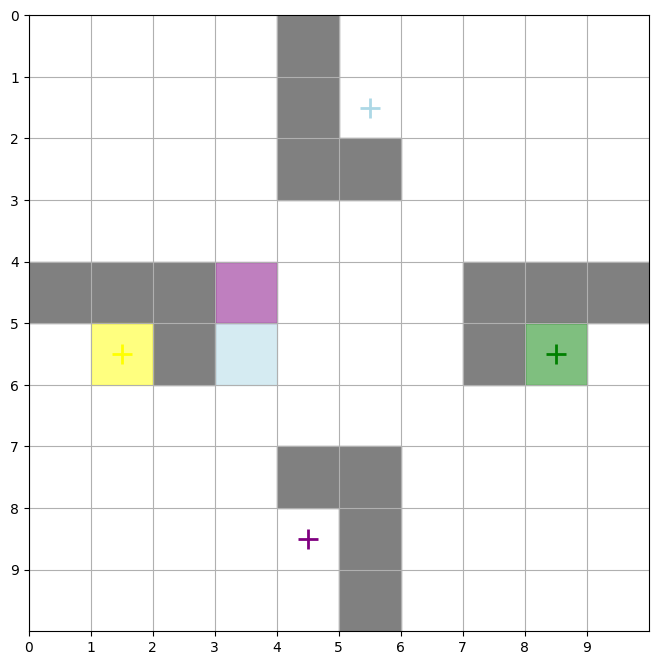

Step 31:


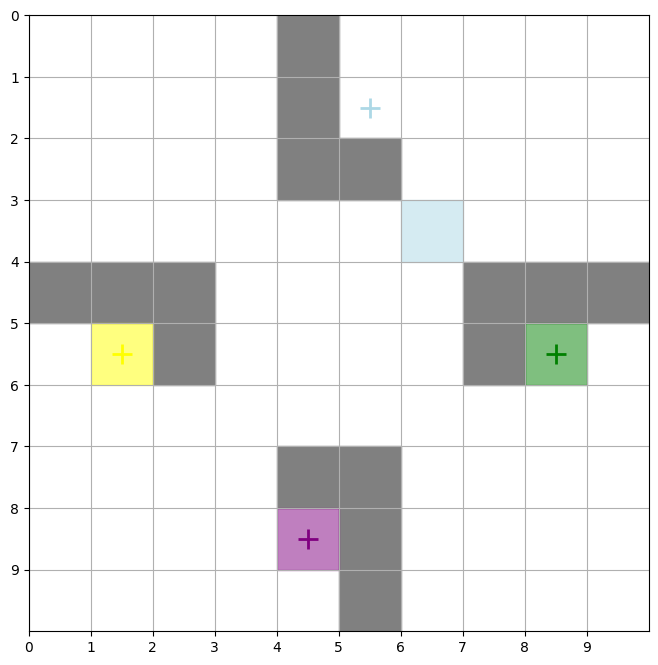

Step 36:


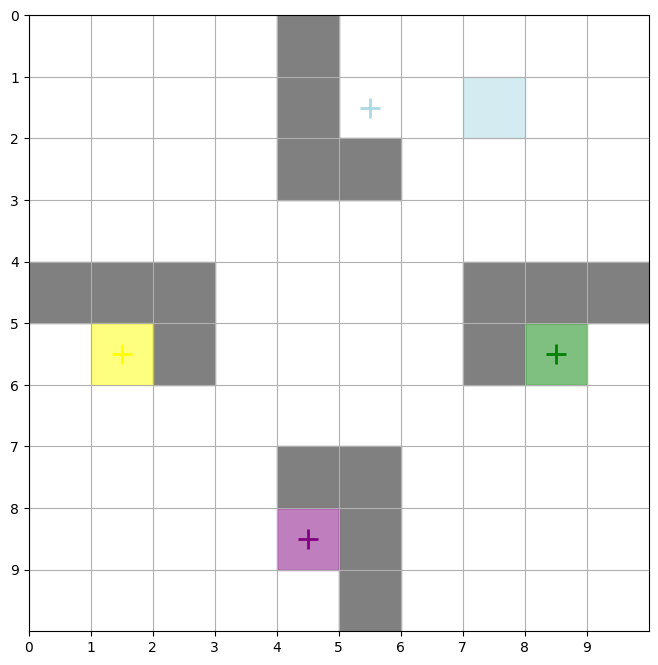

Step 41:


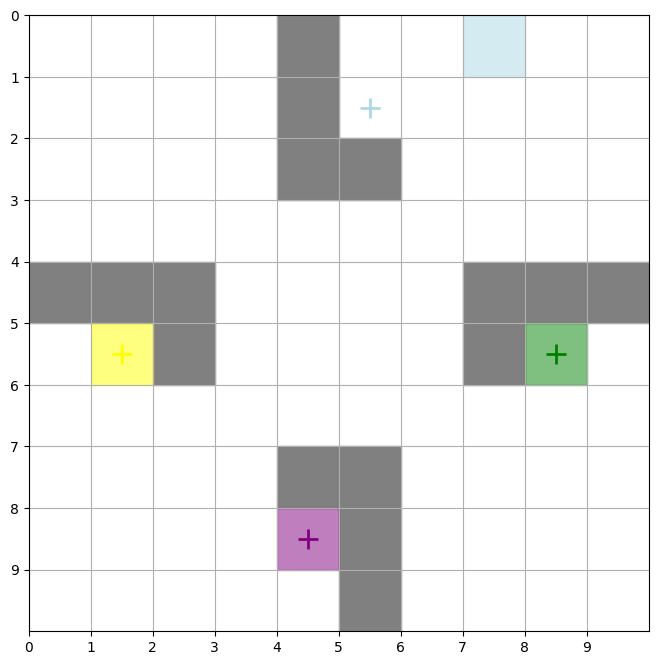

Step 46:


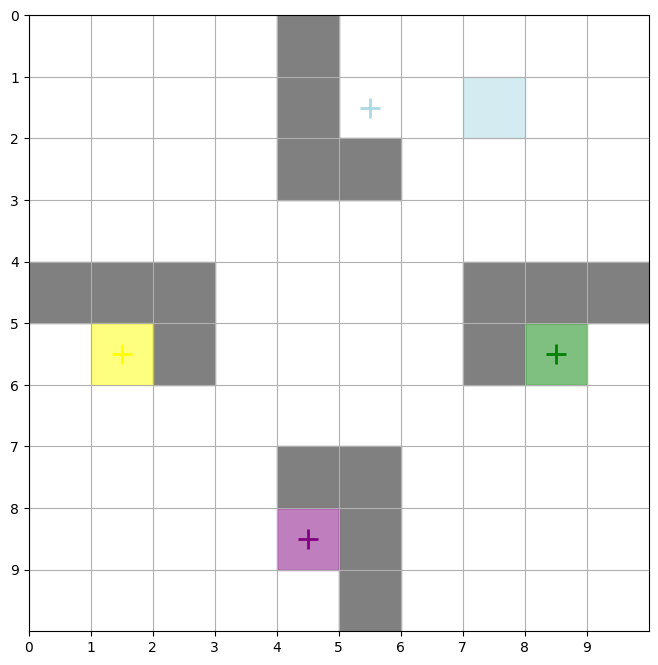

Step 51:


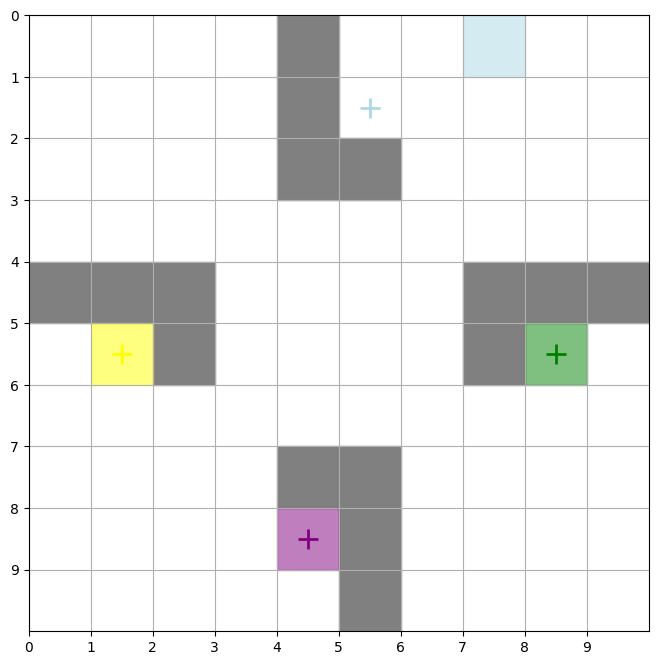

Step 56:


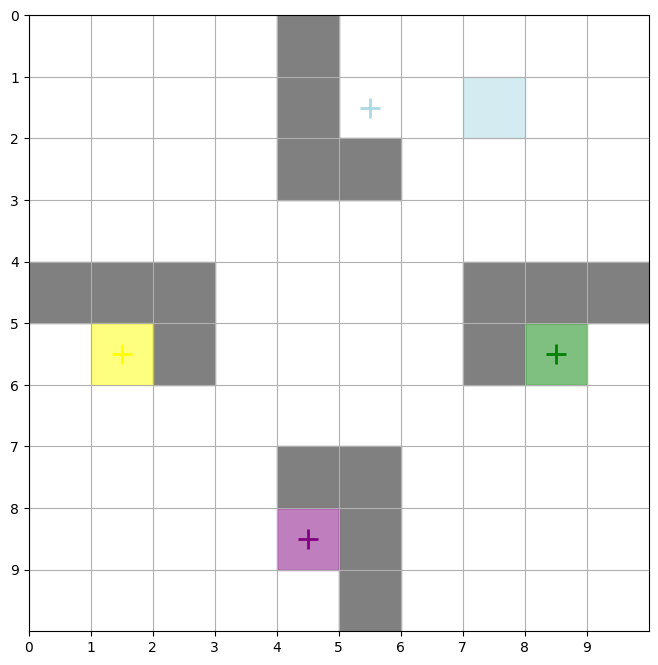

Step 61:


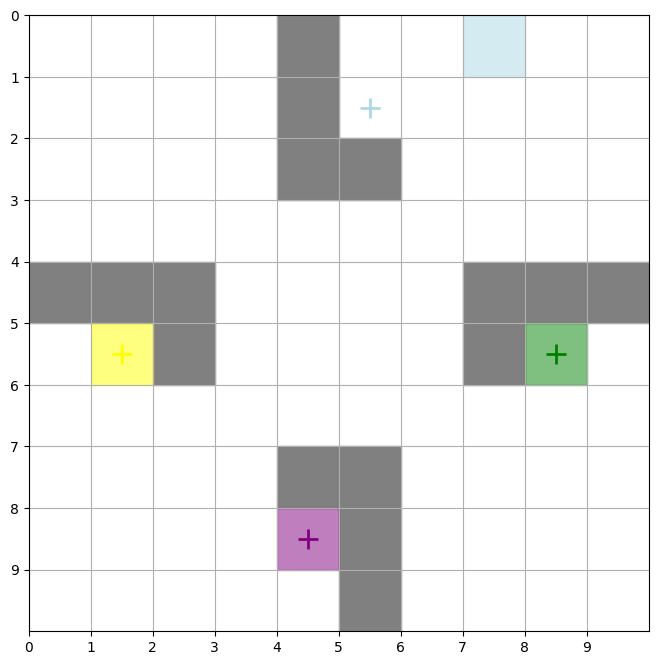

Step 66:


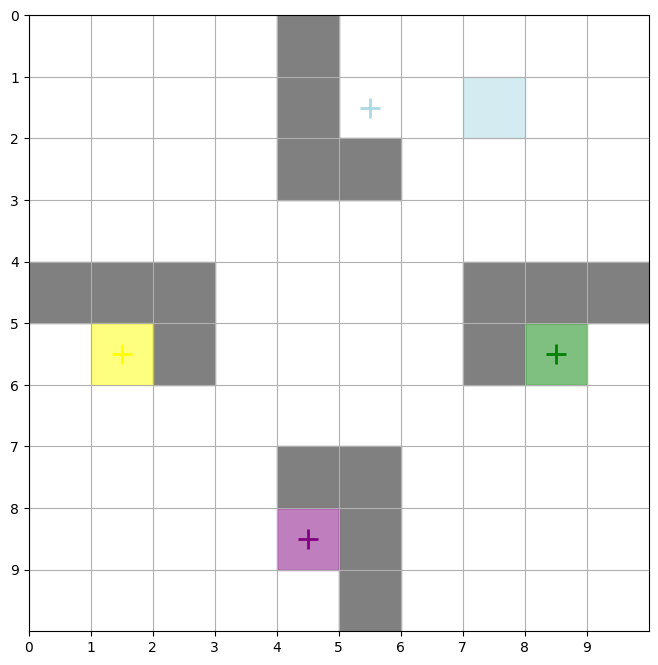

Step 71:


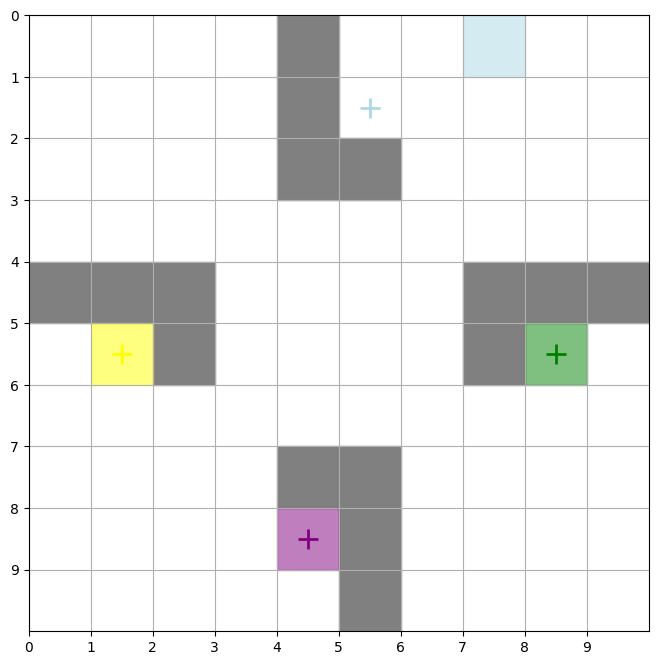

Step 76:


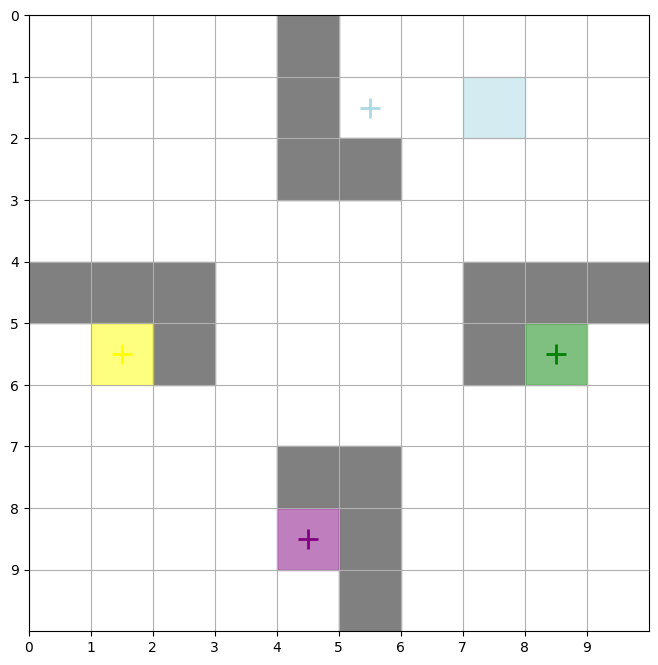

Step 81:


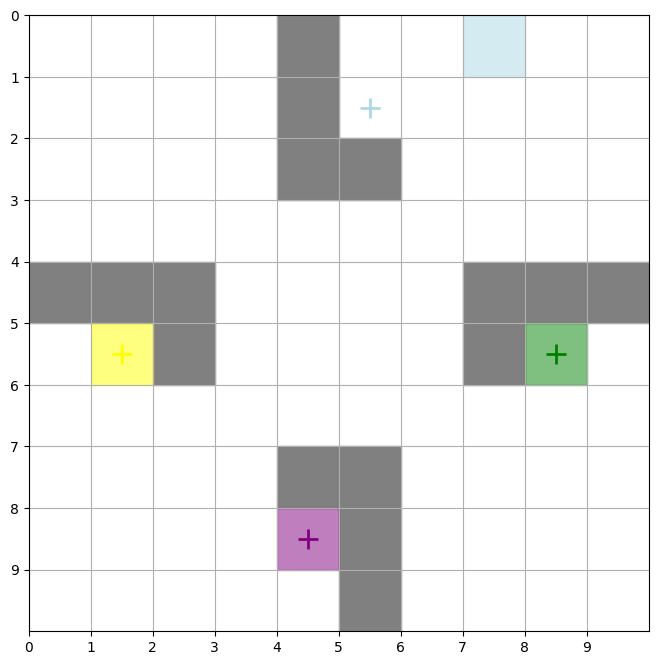

Step 86:


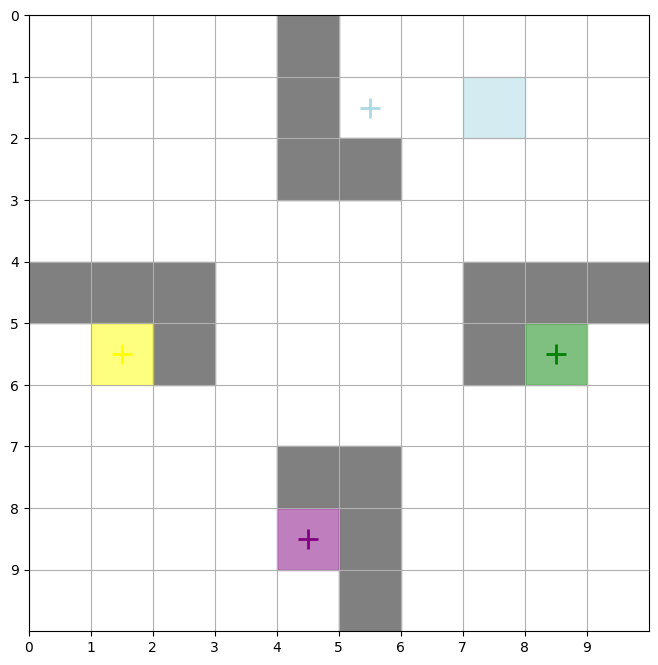

Step 91:


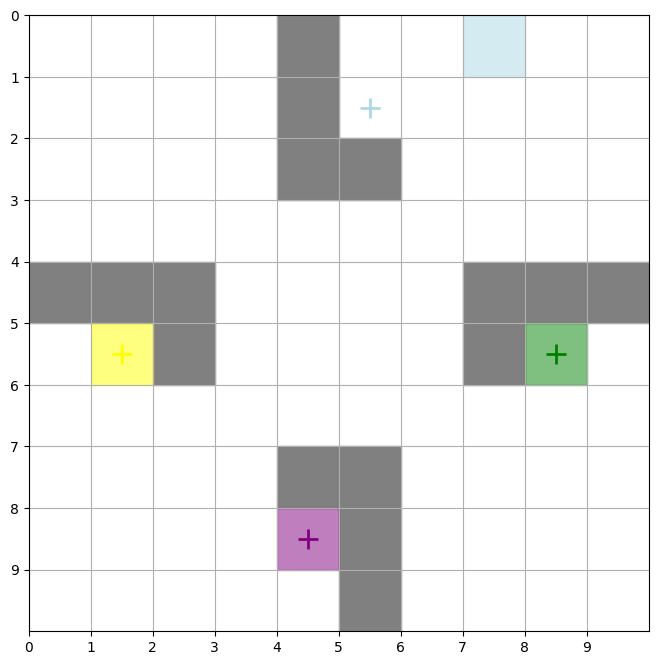

Step 96:


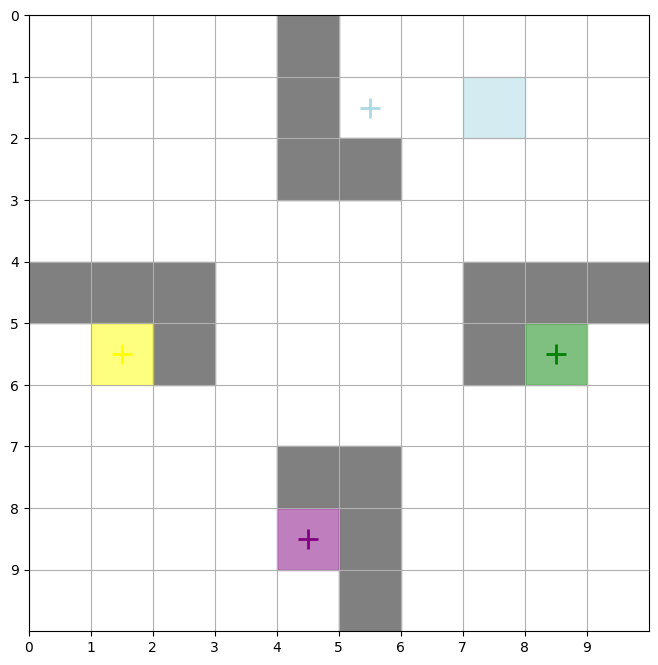

Maximum steps reached before all agents could reach their goals.


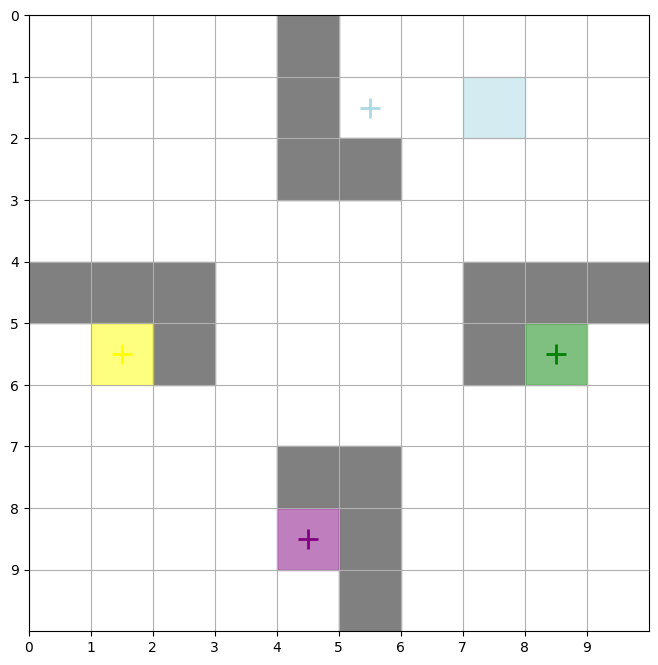

In [13]:
mapf.test(max_steps=100)
env.visualize()